In [1]:
import sys
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd

sys.path.append('..')
import ptm_recommender.graph_models.graph_util as util
from ptm_recommender.graph_models.gcnn.gin_utils import graph_to_s2vgraphs

torch.set_num_threads(2)
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
task_to_metric = {
            "mrpc" : "eval_accuracy",  "cola" : "matthews_correlation", 
            "rte" :'accuracy', "sst2" :'accuracy', "stsb" :'pearson',
            "wnli" :'accuracy', "squad_v2": "f1", "mnli": "accuracy", 
            "qnli": "accuracy", "qqp": "accuracy"
}

base_model_list = [
    "albert-base-v2", 
    "albert-large-v2",
    "bert-base-uncased", 
    "bert-large-uncased", 
    "distilbert-base-uncased",
    "distilroberta-base", 
    "electra-base-discriminator",
    "electra-large-discriminator",
    "roberta-base", 
    "roberta-large",
    "xlm-roberta-base", 
    "xlm-roberta-large"
]

base_model_to_color={
    "albert-base-v2": 'tab:blue',
    "albert-large-v2":'tab:blue',
    "bert-base-uncased": 'tab:orange',
    "bert-large-uncased": 'tab:orange',
    "distilbert-base-uncased":'tab:purple',
    "distilroberta-base": 'tab:purple',
    "electra-base-discriminator": 'tab:pink',
    "electra-large-discriminator":'tab:pink',
    "roberta-base": 'tab:olive',
    "roberta-large": 'tab:olive',
    "xlm-roberta-base": 'tab:cyan',
    "xlm-roberta-large": 'tab:cyan'
}

base_model_to_hatch={
    "albert-base-v2": None,
    "albert-large-v2":'//', 
    "bert-base-uncased": None,
    "bert-large-uncased": '//',
    "distilbert-base-uncased":None, 
    "distilroberta-base": '//', 
    "electra-base-discriminator": None, 
    "electra-large-discriminator":'//', 
    "roberta-base": None, 
    "roberta-large": '//',
    "xlm-roberta-base": None, 
    "xlm-roberta-large": '//'
}

# Task for title
task_title = {
    "cola":'CoLA', 
    "mrpc":'MRPC',
    "rte" :'RTE', 
    "sst2" :'SST2', 
    "stsb" :'STSB',
    "wnli" :'WNLI', 
    "squad_v2": 'SQuADv2',
    "mnli": 'MNLI', 
    "qnli": 'QNLI', 
    "qqp": 'QQP'
}

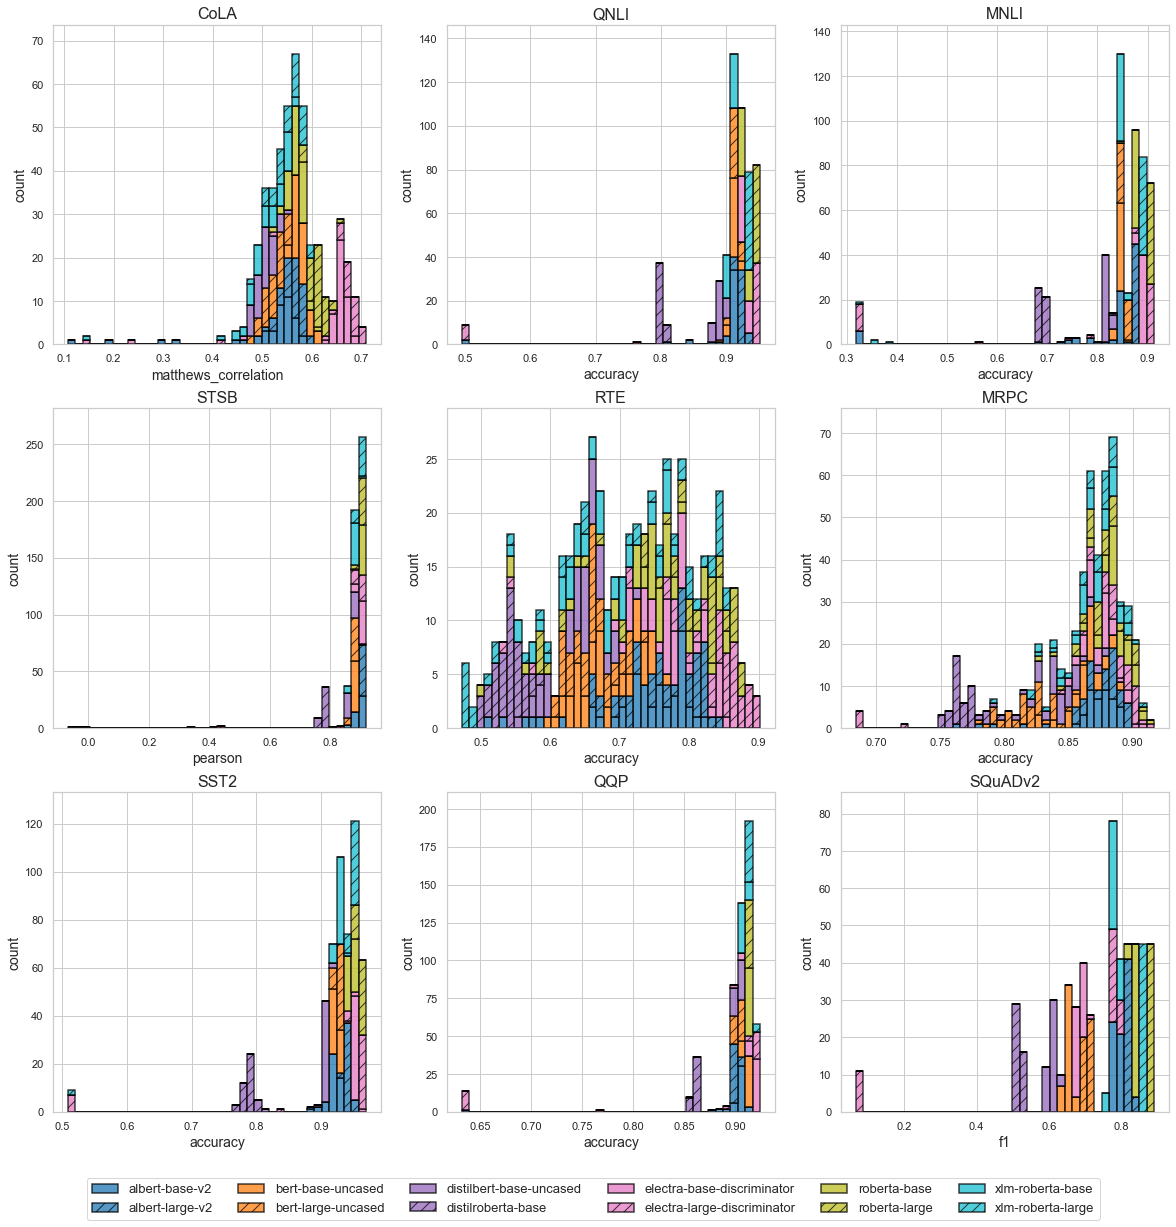

In [16]:
# 각 dataset마다 distribution plot+

task_to_metric = {
            "mrpc" : "eval_accuracy",  "cola" : "eval_matthews_correlation", #"cola" : "eval_accuracy",
            "rte" :'eval_accuracy', "sst2" :'eval_accuracy', "stsb" :'eval_pearson',
             "squad_v2": "f1", "mnli": "eval_accuracy",
            "qnli": "eval_accuracy", "qqp": "eval_accuracy"
}
label_task_to_metric = {
            "mrpc" : "accuracy",  "cola" : "matthews_correlation", #"cola" : "eval_accuracy",
            "rte" :'accuracy', "sst2" :'accuracy', "stsb" :'pearson',
             "squad_v2": "f1", "mnli": "accuracy",
            "qnli": "accuracy", "qqp": "accuracy"
}

# Define font properties for labels and titles
label_font = {'size': 14}
title_font = {'size': 16}

tasks =['cola', 'qnli', 'mnli', 'stsb','rte','mrpc', 'sst2','qqp','squad_v2']
def load_accuracy_for_base_model(task, base_model):
    with open(f'../ptm_model_bench/performance/merged_models/{task}_performance_score.json') as f:
        perf = json.load(f)
    perf_list= [i[task_to_metric[task]]  for k, i in perf[task].items() if k.split('_')[0] == base_model]
    if task == 'squad_v2':
        perf_list = [x/100 for x in perf_list]
    if task == 'cola':
        perf_list = [x for x in perf_list if x>0.1]
    return perf_list

# Set the style for the plots
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for tdx, (task, ax) in enumerate(zip(tasks, axes.flat)):
    dist = {}
    dist['group']=[]
    dist[label_task_to_metric[task]]=[]
    for idx, base_model in enumerate(base_model_list):
        y=load_accuracy_for_base_model(task, base_model)
        dist[label_task_to_metric[task]]+= y
        dist['group']+= [base_model]*len(y)

    data = pd.DataFrame(dist)
    groups = data['group'].unique()
    bins = np.linspace(data[label_task_to_metric[task]].min(), data[label_task_to_metric[task]].max(), int(1/0.025)+1)
    bottom = np.zeros(len(bins) - 1)
    for group in groups:
        group_data = data[data['group'] == group][label_task_to_metric[task]]
        heights, _ = np.histogram(group_data, bins=bins)
        bar_container = ax.bar(bins[:-1], heights, width=np.diff(bins), bottom=bottom, align='edge',
                               color=base_model_to_color[group], edgecolor='black', linewidth=1.5,
                               hatch=base_model_to_hatch[group], label=group, alpha=0.75)
        # Update the bottom of the bars for the next group
        bottom += heights
    ax.set_ylim(0, max(bottom) * 1.1)
    ax.set_xlabel(label_task_to_metric[task],fontdict=label_font)
    ax.set_ylabel('count',fontdict=label_font)
    ax.set_title(f'{task_title[task]}',fontdict=title_font)

handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), ncol=6, loc='lower center', bbox_to_anchor=(0.5, 0.05), borderaxespad=0., fontsize=13)

# plt.show()
fig.savefig('dataset_distribution_model.png', dpi=200)